In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from scipy.optimize import linprog

class RationalClassifier:
    def __init__(self, numerator_degree, denominator_degree, n_components, delta=1e-5, precision=1e-3):
        self.numerator_degree = numerator_degree
        self.denominator_degree = denominator_degree
        self.n_components = n_components
        self.delta = delta
        self.precision = precision
        self.alpha = None
        self.beta = None
        self.z = None
        self.classifiers = {}

    def fit(self, X, y):
        """
        Train the rational classifier by solving for optimal alpha, beta, and z.
        """
        for cls in range(10):
            # Binarize the labels: current digit vs. other digits (One-vs-All)
            y_binary = np.where(y_train == cls, 1, 0)

            # Generate rational function matrices
            G_matrix, H_matrix = generate_rational_function_matrix(
                self.numerator_degree, self.denominator_degree, self.n_components, X
            )

            # Use bisection method to find optimal z
            self.z = bisection_method(
                uL=0, uH=100, G_matrix=G_matrix, H_matrix=H_matrix, y=y_binary, precision=self.precision
            )

            # Solve for alpha and beta at the optimal z
            result = solve_lp(self.z, G_matrix, H_matrix, y_binary, delta=self.delta)
            if not result.success:
                raise ValueError(f"Linear programming failed to converge for digit {cls}.")

            # Store the coefficients for each digit's classifier
            self.classifiers[cls] = {
                'alpha': result.x[1:1 + G_matrix.shape[1]],
                'beta': result.x[1 + G_matrix.shape[1]:]
            }

    def predict(self, X):
        """
        Predict class labels for input data X.
        """
        predictions = []
        for x in X:
            class_scores = {}

            # Compute scores for each classifier (digit 0-9)
            for cls, coeffs in self.classifiers.items():
                alpha = coeffs['alpha']
                beta = coeffs['beta']

                # Generate rational function matrices for prediction
                G_matrix, H_matrix = generate_rational_function_matrix(
                    self.numerator_degree, self.denominator_degree, self.n_components, [x]
                )

                # Compute rational function values
                numerator = np.dot(G_matrix, alpha)
                denominator = np.dot(H_matrix, beta)+1e-5 
                rational_value = numerator / denominator

                class_scores[cls] = rational_value

            # Choose the class (digit) with the highest score
            predicted_digit = max(class_scores, key=class_scores.get)
            predictions.append(predicted_digit)

        return np.array(predictions)


# Helper functions to generate rational function matrices
def generate_multi_indices(n, d):
    from itertools import chain
    return list(chain(*[list(r_multi_indices(n, _)) for _ in range(d + 1)]))

def generate_rational_function_matrix(numerator_degree, denominator_degree, n_components, dataset):
    G_indices = generate_multi_indices(n_components, numerator_degree)
    H_indices = generate_multi_indices(n_components, denominator_degree)

    G_matrix = np.zeros((len(dataset), len(G_indices)))
    H_matrix = np.zeros((len(dataset), len(H_indices)))

    for i, data_point in enumerate(dataset):
        G_matrix[i] = [np.prod([data_point[k] ** idx[k] for k in range(len(data_point))]) for idx in G_indices]
        H_matrix[i] = [np.prod([data_point[k] ** idx[k] for k in range(len(data_point))]) for idx in H_indices]

    return G_matrix, H_matrix

def r_multi_indices(n, d):
    if n == 1:
        yield (d,)
    else:
        for k in range(d + 1):
            for c in r_multi_indices(n - 1, k):
                yield (d - k, *c)

def solve_lp(z, G_matrix, H_matrix, y, delta=1e-5):
    y = np.asarray(y)  # Ensure y is a NumPy array
    length_dataset = len(y)
    num_alpha = G_matrix.shape[1]
    num_beta = H_matrix.shape[1]

    c = [1] + [0] * (num_alpha + num_beta)
    A_ub, b_ub = [], []

    for i in range(length_dataset):
        G_row = G_matrix[i]
        H_row = H_matrix[i]
        y_i = y[i]

        # First constraint
        A_ub.append([-1] + [-g for g in G_row] + [(y_i - z) * h for h in H_row])
        b_ub.append(0)

        # Second constraint
        A_ub.append([-1] + [g for g in G_row] + [-(y_i - z) * h for h in H_row])
        b_ub.append(0)

        # Positivity constraint
        A_ub.append([0] + [0] * num_alpha + [-h for h in H_row])
        b_ub.append(-delta)

    bounds = [(0, None)] + [(None, None)] * (num_alpha + num_beta)
    result = linprog(c=c, A_ub=np.array(A_ub), b_ub=np.array(b_ub), bounds=bounds, method="highs")
    return result

def bisection_method(uL, uH, G_matrix, H_matrix, y, precision=1e-6):
    y = np.asarray(y)  # Ensure y is a NumPy array

    while (uH - uL) > precision:
        z = (uH + uL) / 2
        result = solve_lp(z, G_matrix, H_matrix, y)

        if result.success:
            uH = z
        else:
            uL = z

    return uH






In [3]:

##### LOADING DATA ####




# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target.astype(int)

# Randomly select 500 samples from the dataset
subset_size = 2000
indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X.iloc[indices]  # Use .iloc for row selection
y_subset = y.iloc[indices]

# Normalize the features
scaler = MinMaxScaler()
X_subset_scaled = scaler.fit_transform(X_subset)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_subset_scaled, y_subset, test_size=0.2, random_state=42
) 

In [ ]:

###### TRAINING PHASE ########





import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 
from sklearn.metrics import accuracy_score, classification_report
from scipy.optimize import linprog
 

# Apply PCA for dimensionality reduction
n_components = 22
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize the RationalClassifier with degrees for numerator and denominator
numerator_degree = 2 # You can adjust the degree as needed
denominator_degree = 1

#classifier defined
classifier = RationalClassifier(numerator_degree, denominator_degree, n_components)

# Train the model using the training data
classifier.fit(X_train_pca, y_train)



Accuracy: 0.9000

Classification Report:
              precision    recall  f1-score   support

           0     0.9268    0.9500    0.9383        40
           1     0.8889    0.9412    0.9143        34
           2     0.9362    0.8980    0.9167        49
           3     0.8679    0.9787    0.9200        47
           4     0.9062    0.9355    0.9206        31
           5     0.8621    0.8065    0.8333        31
           6     0.9412    0.9412    0.9412        34
           7     0.9167    0.9167    0.9167        60
           8     0.9091    0.7143    0.8000        42
           9     0.8286    0.9062    0.8657        32

    accuracy                         0.9000       400
   macro avg     0.8984    0.8988    0.8967       400
weighted avg     0.9012    0.9000    0.8986       400



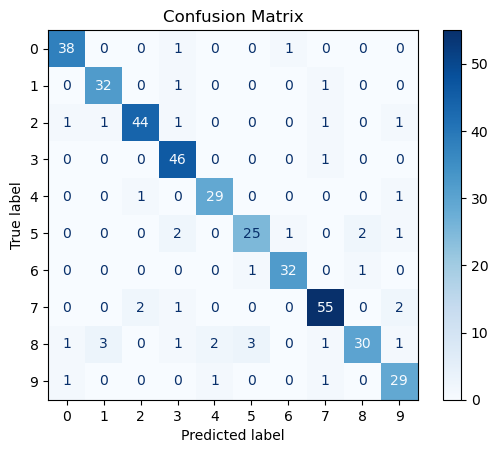

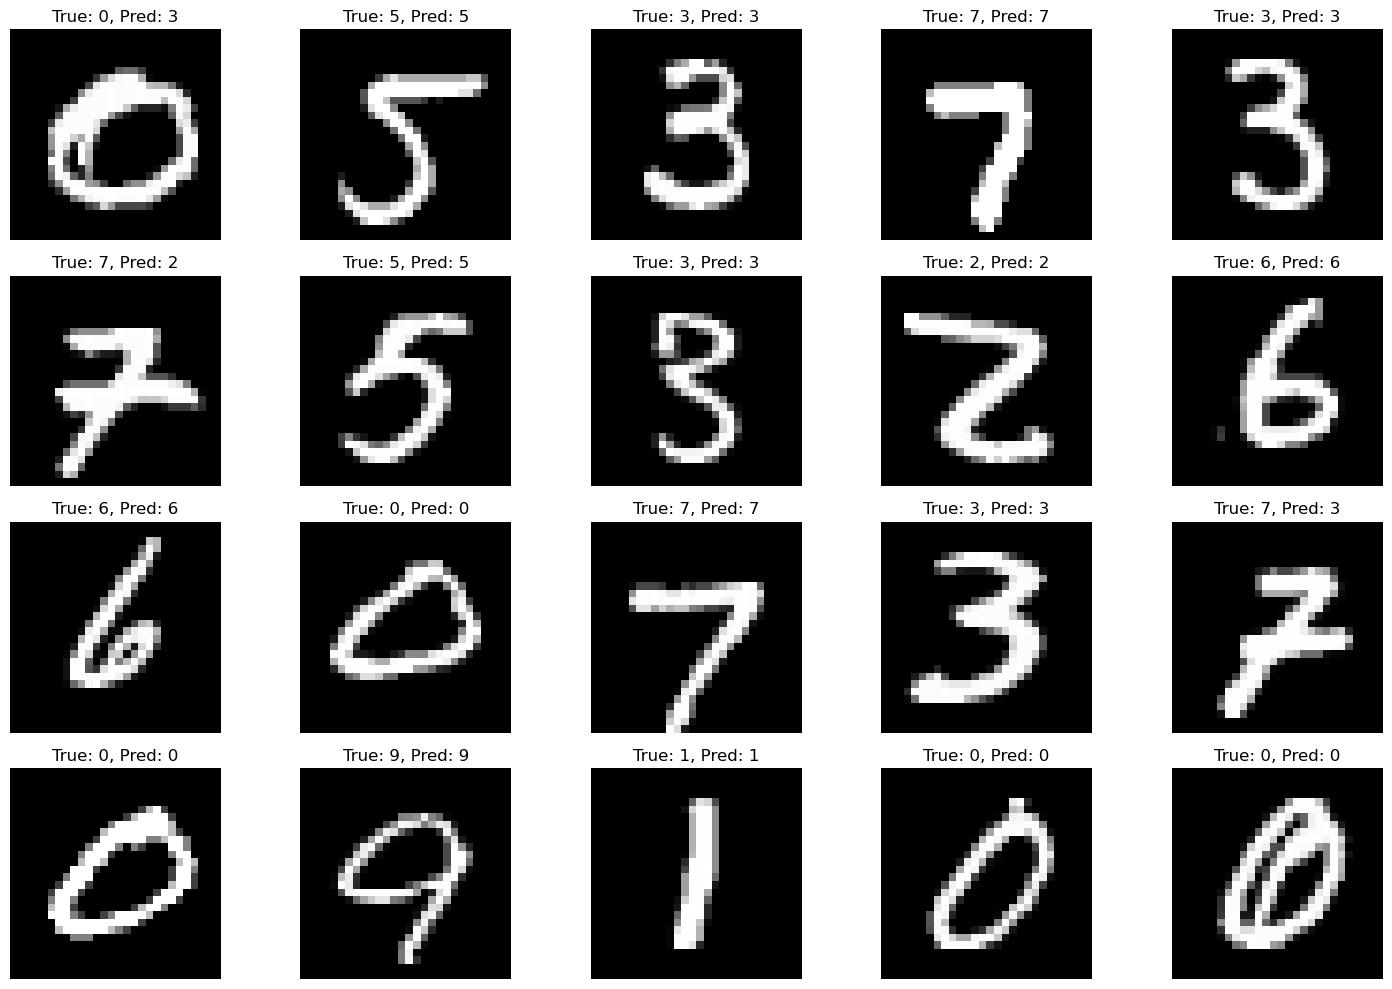

In [ ]:

###### TESTING PHASE  #############


from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Predict on the entire test set
y_pred = classifier.predict(X_test_pca)







#######  Evaluation phase  ############

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification report (Precision, Recall, F1-score, and Support)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Visualize the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
# ---- Visualize Multiple Images ---- #
def visualize_images(num_images=20):
    plt.figure(figsize=(15, 10))  # Adjust figure size for better visibility

    for i in range(num_images):
        index = i  # Select the first `num_images` indices
        new_image = X_test[index] if isinstance(X_test, np.ndarray) else X_test.iloc[index]
        true_digit = y_test.iloc[index] if hasattr(y_test, 'iloc') else y_test[index]
        predicted_digit = y_pred[index]

        # Reshape the image for display
        reshaped_image = new_image.reshape(28, 28)

        # Plot the image with prediction and true label
        plt.subplot(4, 5, i + 1)  # Create a grid of 2 rows and 5 columns
        plt.imshow(reshaped_image, cmap='gray')
        plt.title(f"True: {true_digit}, Pred: {predicted_digit}")
        plt.axis('off')  # Hide axes for cleaner visualization
        
    plt.tight_layout()
    plt.show()

# Visualize the first 10 images
visualize_images(num_images=20)